# 

In [1]:

def plot_by_dataset(chunk_duration: float, metric: str="delay", measure_sym: str ="s", ymin_offset=0.0, ymax_offset=0.0, data_dir: str = "final-test-results/std", loc_legend="upper right", bbox_to_anchor=(0,1), save_pdf=False):
    import os
    import re
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as pe
    from matplotlib.patches import Patch

    #Set latex font
    #plt.rc("text", usetex=True)
    #plt.rc("font", family="serif")

    short_names = {
        "librispeech": "Librispeech-Long",
        "gogfleaurs": "Google-Fleurs",
        "multilibri": "Multilingual-Librispeech",
        "ita_parkinson": "Italian-Parkinson-Voices",
    }

    def map_dataset(fname):
        name = next((k for k in short_names if k in fname), None)
        return short_names[name] if name else None

    def extract_clients(fname):
        m = re.search(r'(\d+)', fname)
        return int(m.group(1)) if m else None

    data = {}

    for fname in os.listdir(data_dir):
        if f"{chunk_duration}" not in fname:
            continue

        ds = map_dataset(fname)
        clients = extract_clients(fname)

        if ds is None or clients is None:
            continue

        df = pd.read_csv(os.path.join(data_dir, fname), sep=';')
        values = df[metric].dropna().tolist()
        if values:
            data.setdefault(ds, {}).setdefault(clients, []).extend(values)


    client_colors = {
        5:  "#ff7f0e",
        10: "#2ca02c",
        15: "#d62728", 
        20: "#9467bd",
        25: "#5462bd",
        30: "#3c164b", 
    }

    dataset_names = ["Multilingual-Librispeech", "Google-Fleurs", "Italian-Parkinson-Voices", "Librispeech-Long"]
    max_groups = max(len(data[ds]) for ds in dataset_names)

    point_spacing = 0.25
    group_spacing = max_groups * point_spacing * 2.15
    group_centers = np.arange(len(dataset_names)) * group_spacing

    box_data = []
    box_colors = []
    positions = []

    for i, ds in enumerate(dataset_names):
        n_clients = sorted(data.get(ds, {}).keys())
        offsets = np.linspace(
            - (len(n_clients) - 1) * point_spacing,
            + (len(n_clients) - 1) * point_spacing,
            len(n_clients)
        )

        for offset, client in zip(offsets, n_clients):
            color = client_colors.get(client)
            if not color:
                continue

            x = pd.Series(data[ds][client])
            box_data.append(data[ds][client])
            box_colors.append(color)
            positions.append(group_centers[i] + offset)

    fig, ax = plt.subplots(figsize=(20, 5.5))
    ax.set_axisbelow(True)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.6, alpha=0.9)

    all_values = [v for lst in data.values() for sub in lst.values() for v in sub]
    y_min = min(all_values) - ymin_offset
    y_max = max(all_values) + ymax_offset
    ax.set_ylim(y_min, y_max)

    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=point_spacing * 2,
        patch_artist=True,
        showfliers=True,
        flierprops=dict(marker='^', markerfacecolor='black', markersize=1)
    )

    # Increase linewidth
    for e in ['whiskers', 'caps', 'boxes', 'medians']:
        for l in bp[e]:
            l.set_linewidth(1.5)
    
    for i, (patch, color) in enumerate(zip(bp['boxes'], box_colors)):
        patch.set_facecolor(color)
        patch.set_alpha(0.9)
        patch.set_edgecolor("black")
        

    for pos, median_line in zip(positions, bp['medians']):
        median_line.set_color("black")
        median_line.set_linewidth(1)
        m = median_line.get_ydata()[0]
        ax.text(pos, m, f"{m:.2f}", ha="center", va="center",
            weight="bold", color="white", fontsize=14, family="monospace",
            path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    ax.set_xticks(group_centers)
    ax.set_xticklabels(dataset_names, rotation=0, ha="center", fontsize=18)
    ax.set_ylabel(f"{metric} ({measure_sym})", fontsize=18)
    
    legend_handles = [
        Patch(facecolor=color, edgecolor="black", label=str(client))
        for client, color in sorted(client_colors.items())
    ]
    ax.legend(
        handles=legend_handles,
        title="Clients",
        title_fontsize=16,
        bbox_to_anchor=bbox_to_anchor,
        loc=loc_legend,
        fontsize=16
    )

    if save_pdf:
        filename = f"{metric}-plot-chunk-{chunk_duration:.1f}.pdf"
        fig.savefig(filename, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


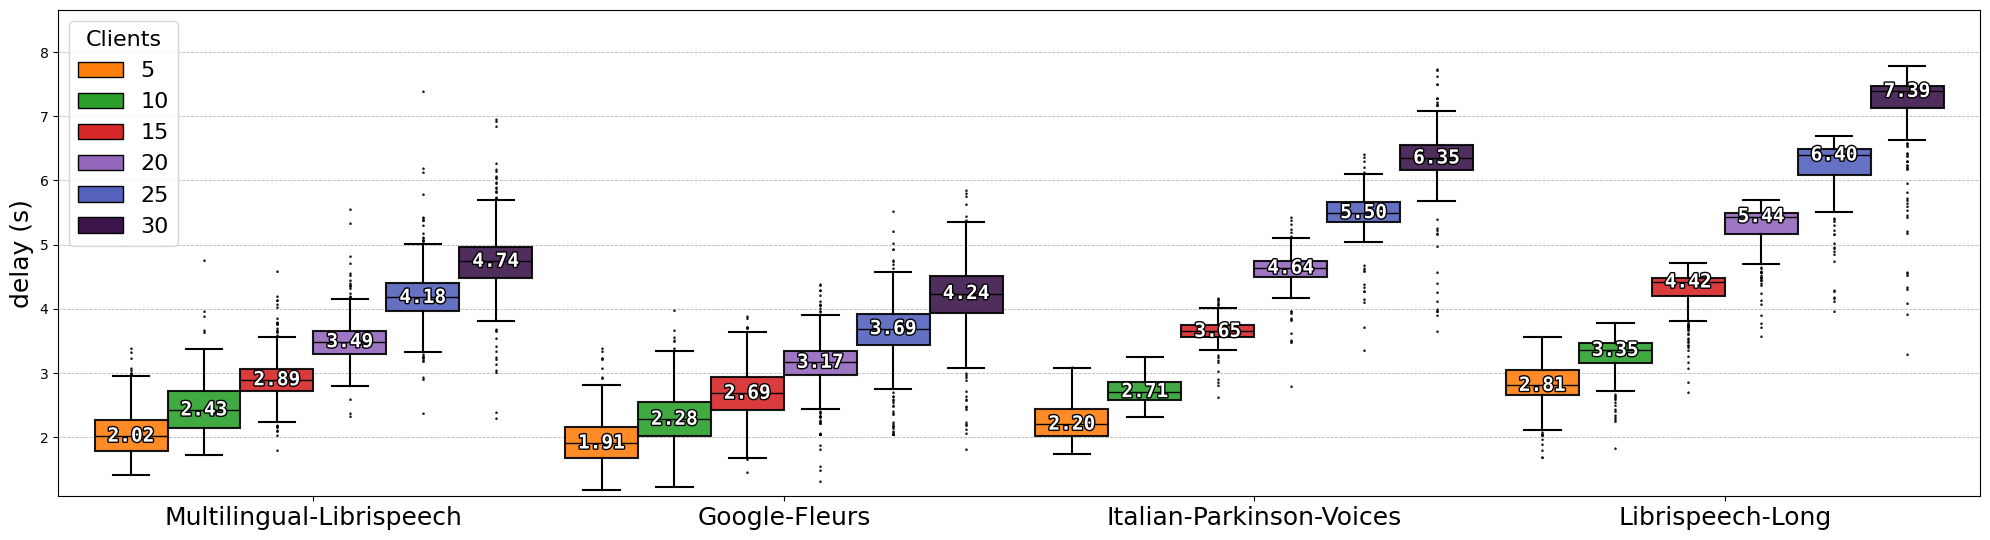

In [2]:
plot_by_dataset(1.0, ymin_offset=0.1, ymax_offset=-0.1, loc_legend="upper left", save_pdf=True)

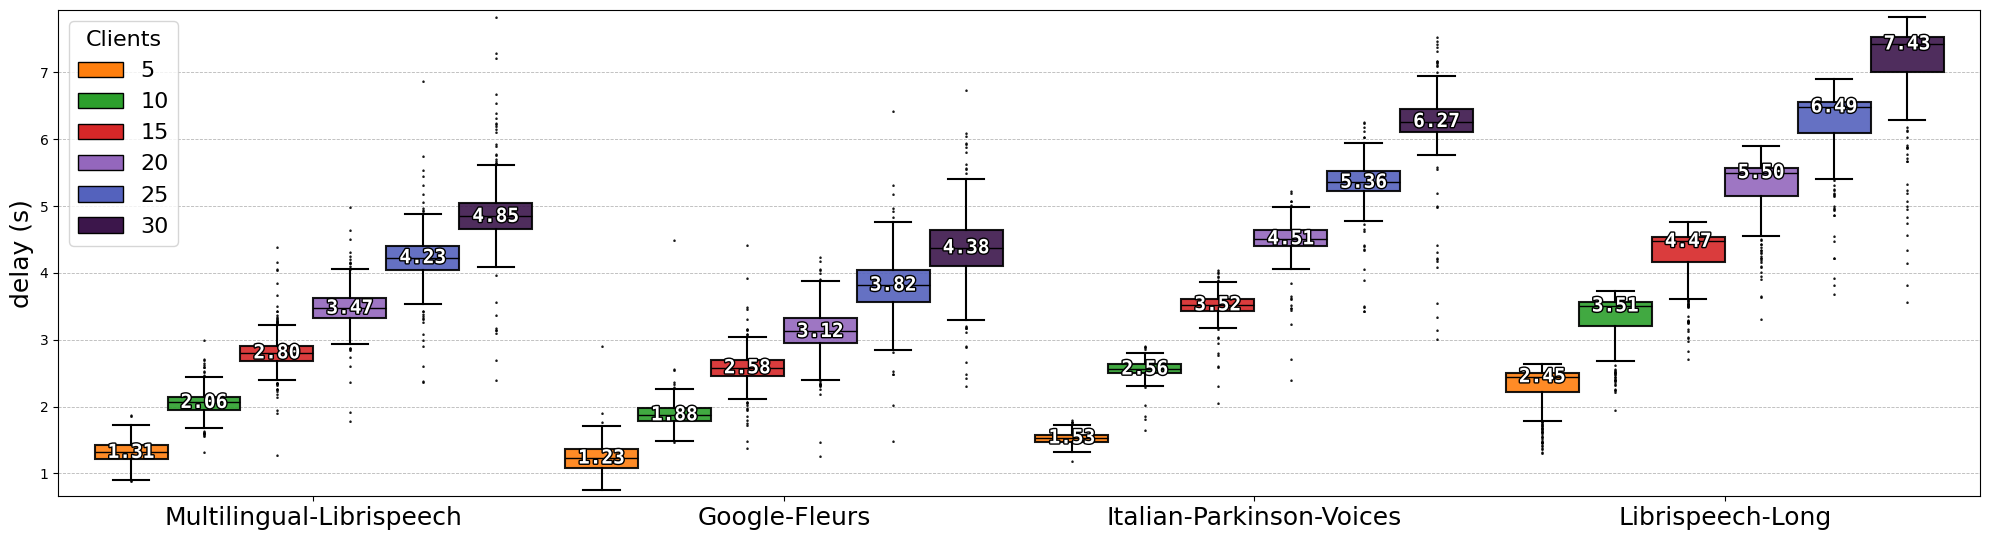

In [3]:
plot_by_dataset(0.5, ymin_offset=0.1, ymax_offset=0.1, loc_legend="upper left", save_pdf=True)

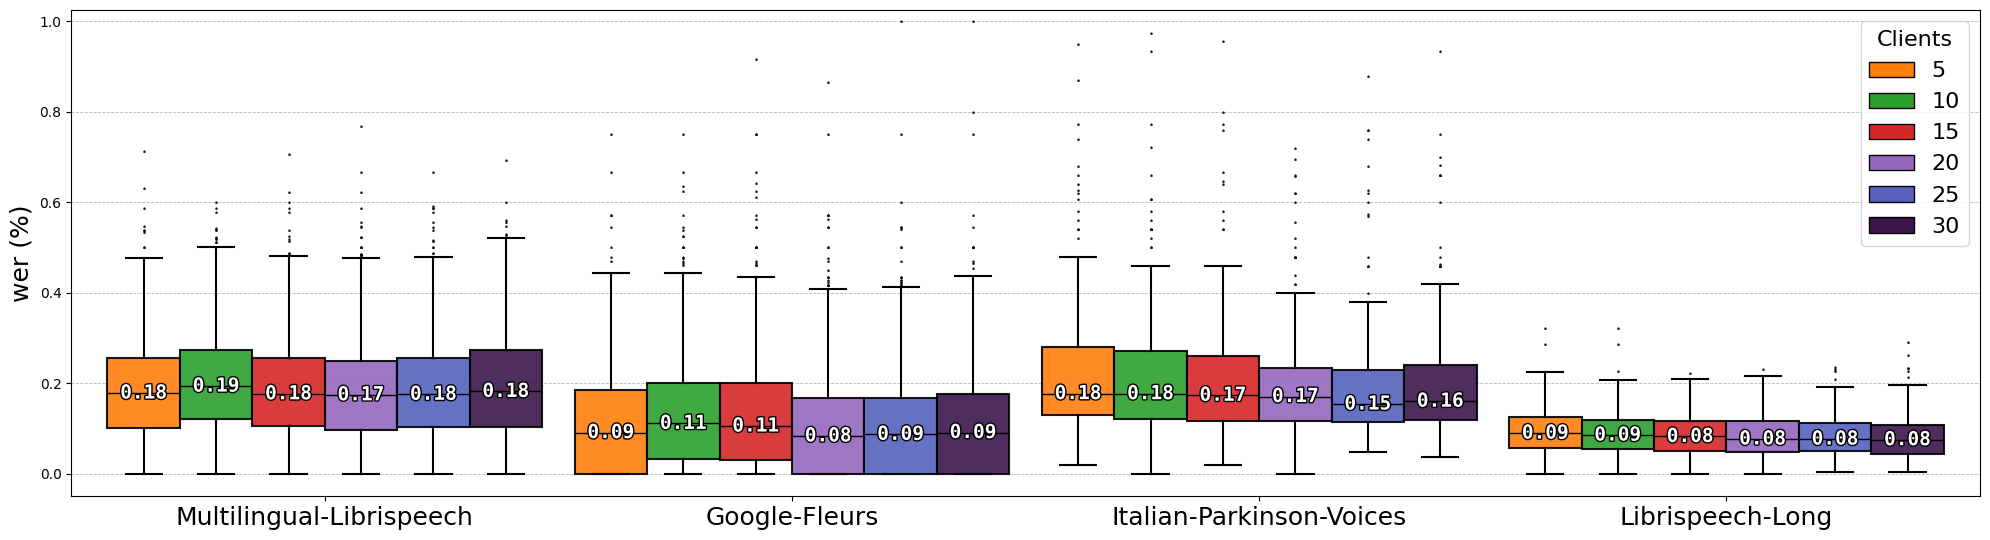

In [4]:
# Escape `%` for LaTeX rendering escape '%' with '\\'
plot_by_dataset(1.0, metric="wer", measure_sym="%", ymin_offset=0.05, ymax_offset=-0.05, bbox_to_anchor=(1,1), save_pdf=True)

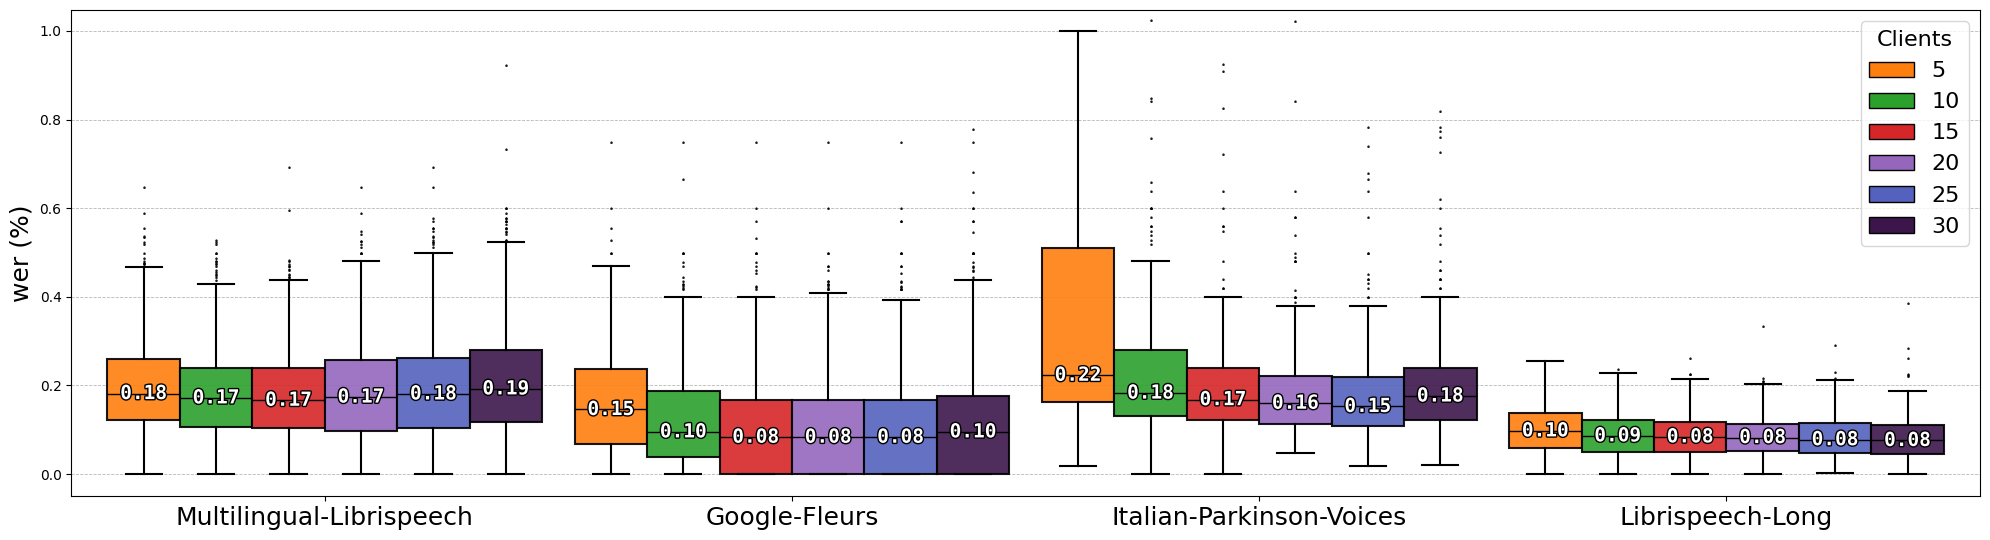

In [5]:
# Escape `%` for LaTeX rendering escape '%' with '\\'
plot_by_dataset(0.5, metric="wer", measure_sym="%", ymin_offset=0.05, ymax_offset=-0.9, bbox_to_anchor=(1,1), save_pdf=True)

In [6]:
def plot_by_nclient_boxen(metric: str = "strict_similarity", measure_sym: str = "%", filter_metric=None, ymin_offset=0.0, ymax_offset=0.0, data_dir: str = "final-test-results/std/", save_pdf=True):
    import os
    import re
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as pe
    import seaborn as sns

    def extract_clients(fname):
        m = re.search(r'(\d+)', fname)
        return int(m.group(1)) if m else None

    client_colors = {
        "5": "#ff7f0e",
        "10": "#2ca02c",
        "15": "#d62728",
        "20": "#9467bd",
        "25": "#5462bd",
        "30": "#3c164b",
    }

    rows = []
    for fname in os.listdir(data_dir):

        clients = extract_clients(fname)
        if clients is None or str(clients) not in client_colors:
            continue

        df = pd.read_csv(os.path.join(data_dir, fname), sep=';')
        if filter_metric:
            df = df[(df[metric] >= filter_metric) & (df["language"] != "ar")]

        for val in df[metric]:
            rows.append({"clients": str(clients), metric: val})

    data_df = pd.DataFrame(rows)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_axisbelow(True)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.6, alpha=0.9)
    ordered_clients = sorted(data_df["clients"].unique(), key=int)

    sns.boxenplot(
        data=data_df,
        x="clients",
        y=metric,
        hue="clients",
        palette=client_colors,
        order=ordered_clients,
        linewidth=2,
        legend=False,
        ax=ax
    )

    

    # Add medians as text
    medians = data_df.groupby("clients")[metric].median()
    for i, client in enumerate(ordered_clients):
        m = medians.loc[client]
        ax.text(i, m, f"{m:.2f}", ha="center", va="center",
                color="white", weight="bold", fontsize=16,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")])


    ax.set_ylabel(f"{metric} ({measure_sym})", fontsize=18)
    ax.set_xlabel("Number of Clients", fontsize=16)
    ax.tick_params(labelsize=14)
    

    # Set y-limits if needed
    all_vals = data_df[metric].values
    y_min = all_vals.min() - ymin_offset
    y_max = all_vals.max() + ymax_offset
    ax.set_ylim(y_min, y_max)

    if save_pdf:
        filename = f"{metric}-boxen-per-client.pdf"
        fig.savefig(filename, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [7]:
plot_by_nclient_boxen(metric="strict_similarity", measure_sym="%", ymin_offset=0.05, filter_metric=80, ymax_offset=1, save_pdf=True)

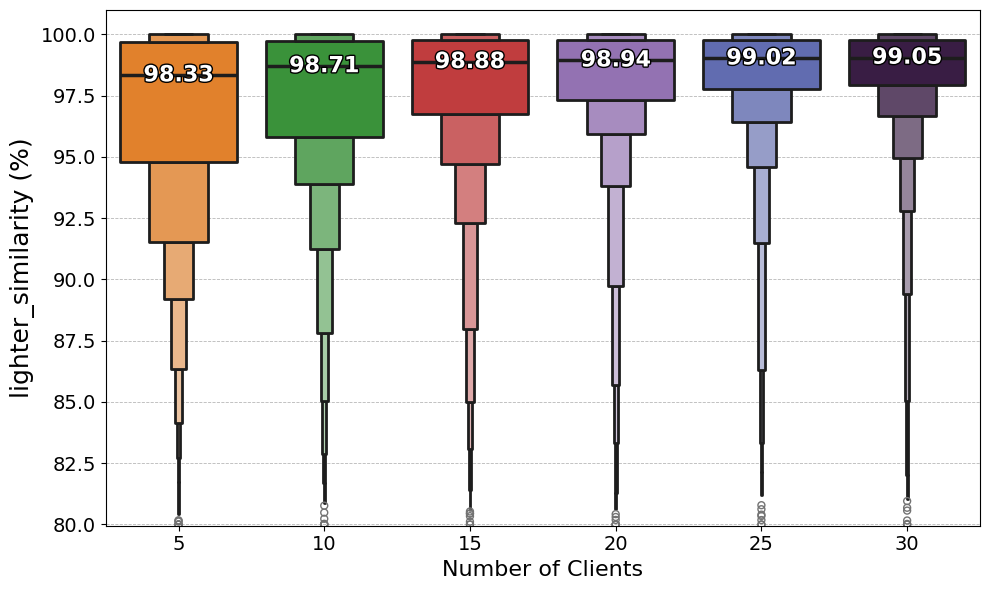

In [8]:
plot_by_nclient_boxen(metric="lighter_similarity", measure_sym="%", ymin_offset=0.05, filter_metric=80, ymax_offset=1, save_pdf=True)

In [9]:
def plot_languages_violin_from_selected_datasets_single(dataset: (str, str), 
                                                        metric: str = "delay", 
                                                        measure_sym: str = "s", 
                                                        ymin_offset=0.0, 
                                                        ymax_offset=0.0, 
                                                        data_dir: str = "final-test-results/std/", 
                                                        loc_legend="upper right", 
                                                        bbox_to_anchor=(0, 1), 
                                                        bw_method=0.2,
                                                        save_pdf=False):
    import os
    import re
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as pe
    import seaborn as sns
    # Patch
    from matplotlib.patches import Patch
    
    color_palette = {
        #"Arabic": "#f6e27f",  # pastel yellow
        "French": "#ff7f0e",
        "English": "#8fd694",  # light green
        "Italian": "#2ca02c",
        "German": "#d62728",
        "Polish": "#86d9f7",  # light blue
        "Portuguese": "#9467bd",
        "Dutch": "#5462bd",
        "Spanish": "#3c164b",
    }

    
    language_label_map = {
        #"ar": "Arabic",
        "fr": "French",
        "en": "English",
        "it": "Italian",
        "de": "German",
        "pl": "Polish",
        "pt": "Portuguese",
        "nl": "Dutch",
        "es": "Spanish"
    }

    def extract_clients(fname):
        m = re.search(r'(\d+)', fname)
        return int(m.group(1)) if m else None

    records = []

    for fname in os.listdir(data_dir):
        if dataset[0] in fname:
            ds = dataset[1]
        else:
            continue

        clients = extract_clients(fname)
        if clients is None:
            continue

        full_path = os.path.join(data_dir, fname)
        df = pd.read_csv(full_path, sep=';')

        if "language" not in df.columns or metric not in df.columns:
            continue

        for _, row in df.iterrows():
            lang_code = row["language"]
            if pd.notna(row[metric]) and lang_code in language_label_map:
                records.append({
                    "language": language_label_map[lang_code],
                    metric: row[metric]
                })

    if not records:
        print("No valid data found.")
        return

    df_long = pd.DataFrame.from_records(records)
        
    languages = df_long["language"].unique()
    palette = color_palette
    #dict(zip(languages, color_palette[:len(languages)]))
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(8, len(languages) * 2.5), 6))
    ax.set_axisbelow(True)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.6, alpha=0.9)
    """sns.violinplot(
        data=df_long,
        x="language",
        y=metric,
        hue="language",        
        palette=palette,
        cut=0,
        inner="box",
        bw_method=bw_method, # Adjust bandwidth for smoother curves
        linewidth=1,
        legend=False,          
        ax=ax,
        order=languages
    )"""
    sns.violinplot(
        data=df_long,
        x="language",
        y=metric,
        hue="language",        
        palette=palette,
        cut=0,
        inner=None,  # Disable the inner line to avoid thick line
        bw_method=bw_method,
        linewidth=2,
        ax=ax,
        order=languages
    )
    
    sns.boxplot(
        data=df_long,
        x="language",
        y=metric,
        whis=[5, 95],  # whiskers to min/max
        showcaps=False, # Remove horizontal line at edges of the boxplot whiskers
        boxprops={'facecolor': 'white', 'edgecolor': 'black', 'linewidth': 1.5},
        whiskerprops={'color': 'black', 'linewidth': 1.5},
        capprops={'color': 'black', 'linewidth': 1.5},
        medianprops={'color': 'black', 'linewidth': 2},
        showfliers=False, 
        width=0.15,
        ax=ax,
        order=languages
    )
    for violin in ax.collections:
        violin.set_alpha(0.9)

    medians = df_long.groupby("language")[metric].median()
    for i, lang in enumerate(languages):
        i = i - 0.15  # Adjust position for better centering
        m = medians[lang]
        ax.text(i, m, 
                f"{m:.2f}".lstrip("0") if m < 1 else f"{m:.2f}", 
                ha="center", va="center", rotation=90,
                weight="bold", color="white", fontsize=22, family="monospace",
                path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    all_values = df_long[metric].values
    ax.set_ylim(min(all_values) - ymin_offset, max(all_values) + ymax_offset)
    #ax.set_xticklabels(languages, rotation=30, ha="right", fontsize=14)
    ax.set_ylabel(f"{metric} ({measure_sym})", fontsize=26)
    #ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.6, alpha=0.9)
    for label in ax.get_xticklabels():
        label.set_fontsize(28)
    ax.set_xlabel('')

    if save_pdf:
        filename = f"{metric}-{dataset[0]}-per-language-violin.pdf"
        fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


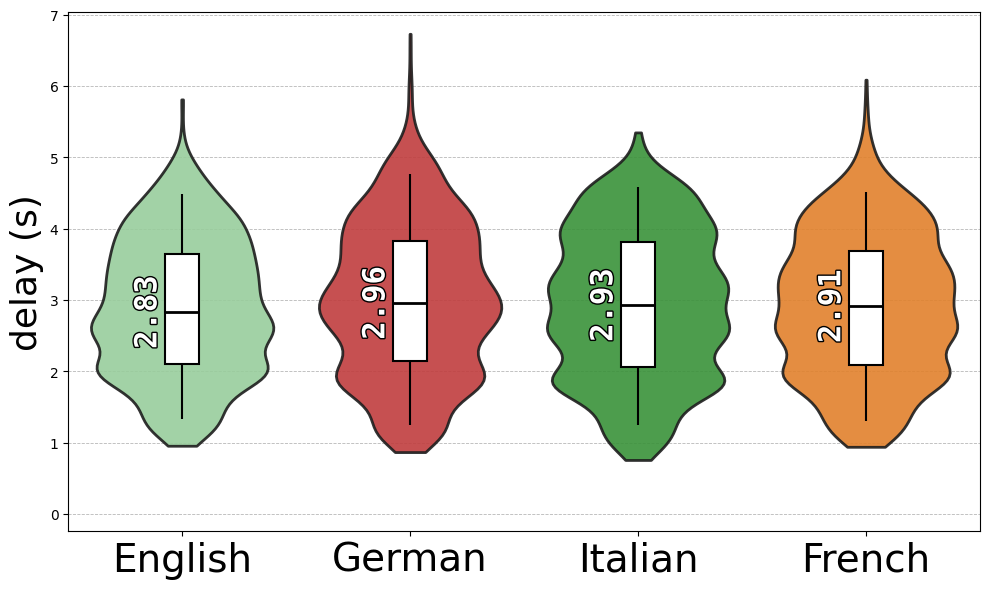

In [10]:
plot_languages_violin_from_selected_datasets_single(("gogfleaurs", "Google-Fleurs"), metric="delay", measure_sym="s", ymin_offset=1, ymax_offset=0.3, loc_legend="upper right", bbox_to_anchor=(1,1), save_pdf=True)

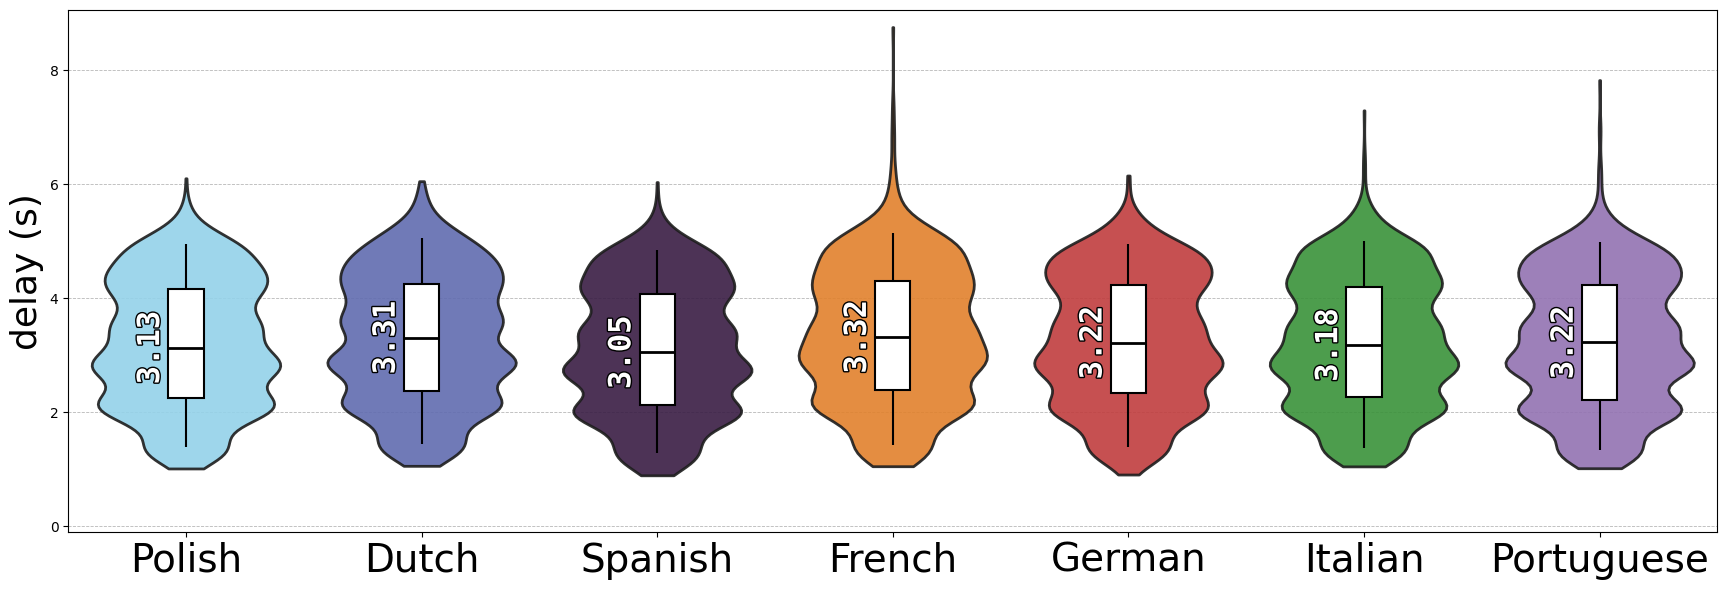

In [11]:
plot_languages_violin_from_selected_datasets_single(("multilibri", "Multilingual-Librispeech"), metric="delay", measure_sym="s", ymin_offset=1, ymax_offset=0.3, loc_legend="upper right", bbox_to_anchor=(1,1), save_pdf=True)

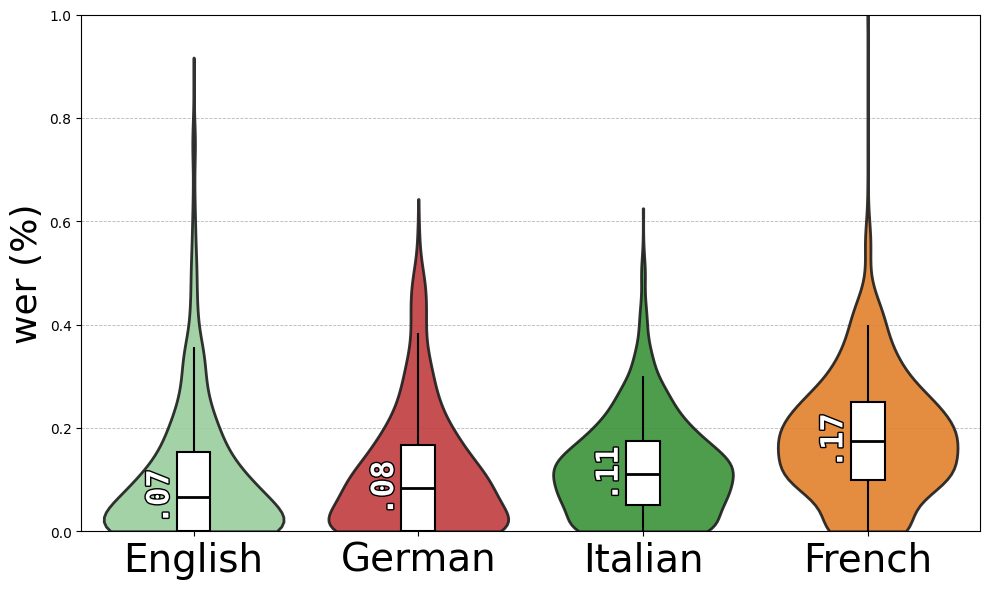

In [12]:
plot_languages_violin_from_selected_datasets_single(("gogfleaurs", "Google-Fleurs"), 
                                                    metric="wer", 
                                                    measure_sym="%", 
                                                    ymin_offset=0, 
                                                    ymax_offset=0, 
                                                    loc_legend="upper right", 
                                                    bbox_to_anchor=(1,1), 
                                                    bw_method=0.3,
                                                    save_pdf=True)


In [13]:
plot_languages_violin_from_selected_datasets_single(("multilibri", "Multilingual-Librispeech"), 
                                                    metric="wer", 
                                                    measure_sym="%", 
                                                    ymin_offset=0, 
                                                    ymax_offset=0, 
                                                    loc_legend="upper right", 
                                                    bbox_to_anchor=(1,1),
                                                    bw_method=0.3,
                                                    save_pdf=True)


In [14]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe

def plot_delay_comparison_bar(std_dir="final-test-results/std", hyp_dir="final-test-results/hypothesis", chunk_duration=1.0, save_pdf= False):
    std_pattern = re.compile(rf"multilibri_short_(\d+)_clients_{chunk_duration}chunksize\.csv")
    hyp_pattern = re.compile(rf"multilibri_short_(\d+)_clients_{chunk_duration}chunksize_hypothesis\.csv")

    std_delays = {}
    hyp_delays = {}


    for fname in os.listdir(std_dir):
        match = std_pattern.match(fname)
        if match:
            clients = int(match.group(1))
            path = os.path.join(std_dir, fname)
            df = pd.read_csv(path, sep=';')
            if "delay" in df.columns:
                mean_delay = df["delay"].dropna().mean()
                std_delays[clients] = mean_delay

    # load hypothesis
    for fname in os.listdir(hyp_dir):
        match = hyp_pattern.match(fname)
        if match:
            clients = int(match.group(1))
            path = os.path.join(hyp_dir, fname)
            df = pd.read_csv(path, sep=';')
            if "delay" in df.columns:
                mean_delay = df["delay"].dropna().mean()
                hyp_delays[clients] = mean_delay

    # Common clients for both datasets
    clients = sorted(set(std_delays.keys()) & set(hyp_delays.keys()))
    confirmed_values = []
    hypothesis_values = []
    ordered_clients = []

    for c in clients:
        confirmed_values.append(std_delays[c])
        hypothesis_values.append(hyp_delays[c])
        ordered_clients.append(c)


    x = np.arange(len(ordered_clients))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 4))
    # Reversed order: Hypothesis first(left), Confirmed then(right)
    #rects1 = ax.bar(x - width/2, hypothesis_values, width, label='Hypothesis', color='#ff7f0e', edgecolor='black', alpha=0.85)
    #rects2 = ax.bar(x + width/2, confirmed_values, width, label='Confirmed', color='#2ca02c', edgecolor='black', alpha=0.85)
    rects1 = ax.bar(x - width/2, hypothesis_values, width, label='Hypothesis', color='#9467bd', edgecolor='black', alpha=0.85)
    rects2 = ax.bar(x + width/2, confirmed_values, width, label='Confirmed', color='#3c164b', edgecolor='black', alpha=0.85)

    ax.set_xlabel('Number of Clients', fontsize=14)
    ax.set_ylabel('Average Delay (s)', fontsize=14)
    #ax.set_title(f'Delay Comparison - Multilibri Short - Chunk {chunk_duration:.1f}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_clients, fontsize=12)
    ax.legend(fontsize=12)
    ax.set_axisbelow(True)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    def annotate_bars(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -10), 
                        textcoords="offset points",
                        ha='center', va='top', fontsize=14,
                        color='white',
                        path_effects=[pe.withStroke(linewidth=1.5, foreground='black')])

    annotate_bars(rects1)
    annotate_bars(rects2)

    if save_pdf:
        filename = f"hypothesis-delay.pdf"
        fig.savefig(filename, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


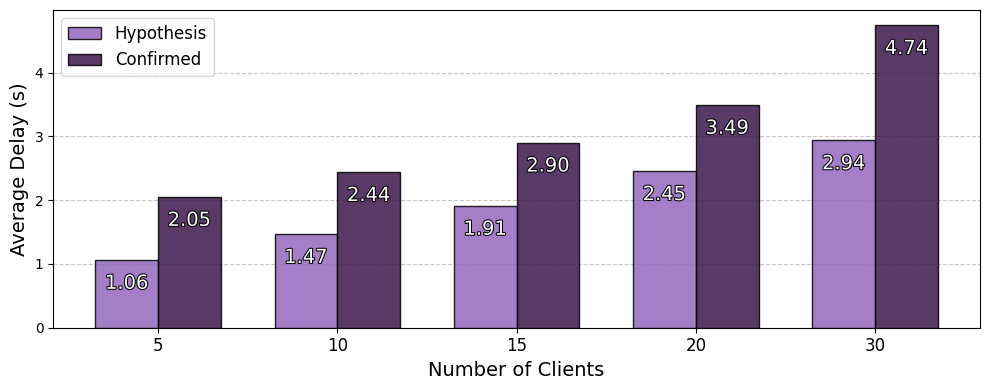

In [15]:
plot_delay_comparison_bar(save_pdf=True)